In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd

In [20]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [22]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [23]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [24]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [25]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)
2016-08-23


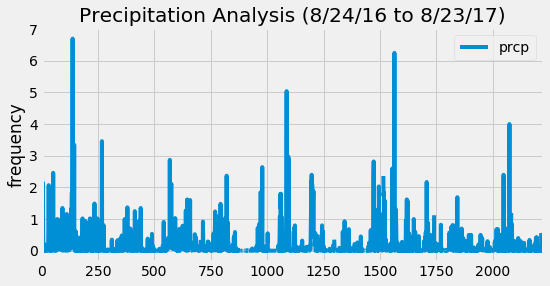

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(date_recent)

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_df = pd.DataFrame(prcp_data)
prcp_data_df.head()

# Sort the dataframe by date
prcp_data_df.set_index('date').head()

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_data_df.plot(figsize=(8,4))
ax.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
ax.set_ylabel('frequency')
plt.show()

![precipitation](Images/precipitation.png)

In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [29]:
# Design a query to show how many stations are available in this dataset?
availability = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations available.".format(availability))

There are 9 stations available.


In [34]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = [Measurement.station, 
       func.count(Measurement.station)]
activestations_query = session.query(*most_active).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
activestations_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_query = engine.execute('SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement WHERE station = "USC00519281"').fetchall()
temp_stats = temp_query[0]
temp_stats

(54.0, 85.0, 71.66378066378067)

In [45]:
# Choose the station with the highest number of temperature observations.
highest_temp_plotquery = engine.execute('SELECT date , tobs FROM measurement WHERE station = "USC00519281" AND date > "2016-08-23"').fetchall()
highest_temp_plotquery

highesttemp_df = pd.DataFrame(highest_temp_plotquery)
highesttemp_df = usc281_df.rename(columns={0: 'date', 1: 'tobs'})
highesttemp_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


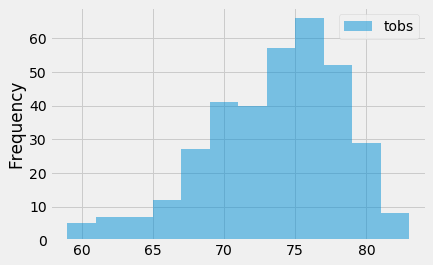

In [46]:
#Highesttemp_df histogram plot for the last 12 months of temperature observation data
highesttemp_df.plot.hist(bins = 12, alpha=.5)

![precipitation](Images/station-histogram.png)

In [47]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


In [49]:
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


([<matplotlib.axis.YTick at 0x1211a6f28>,
 <a list of 15 Text yticklabel objects>)

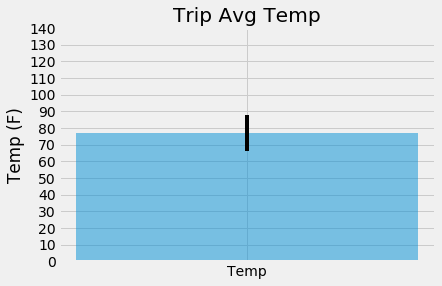

In [59]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
Avg_trip_stats = calc_temps('2016-07-01', '2016-07-08')

trip_yaxis = Avg_trip_stats[0][1]
Avg_trip_min = Avg_trip_stats[0][0]
Avg_trip_max = Avg_trip_stats[0][2]
Avg_error = [Avg_trip_max - Avg_trip_min]

plt.bar("Temp", trip_yaxis, alpha=.5, align = "center", yerr = Avg_error, width=100)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.yticks(np.arange(0, 150, 10))

In [61]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
precipitation_query = engine.execute('SELECT measurement.station, name, latitude, longitude, elevation, AVG(prcp) FROM measurement \
LEFT JOIN station ON measurement.station = station.station \
WHERE date BETWEEN "2016-07-01" AND "2016-07-08" GROUP BY measurement.station ORDER BY AVG(prcp) DESC').fetchall()
precipitation_query

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.785),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.185),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.095),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.088),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.07500000000000001),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.01125),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]